# Generic ALP realignment

In [11]:
%run runner.py
%run observables.py
%run analysis_tools.py
%run plot_tools.py
%run generic_alp.py
import tqdm.notebook
import matplotlib as mpl

## Parameter space from paper

In [12]:
f_a = 1e13
version = 1
data = load_data("generic_alp", version)
eta = recompute_dilution(data, f_a, notebook=True)

  0%|          | 0/900 [00:00<?, ?it/s]

/home/anna-jana/Documents/masters-project/transport_eq_in_time/decay_process.py:13: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(rho_field + rho_rad) * C # NOTE: sometimes with is evalulated at weird arguments -> warnings


In [15]:
interesting_points = [(3e6, 1e10), (9e6, 1e9), (2e9, 1e10), (5e6, 5e6), (1e9, 2e8), (1e10, 4e6)]
interesting_solutions = []
H_inf = data["H_inf"][0]

for m_a, Gamma_inf in tqdm.notebook.tqdm(interesting_points):
    background_sols, axion_sols, red_chem_pot_sols = \
        compute_observables(H_inf, Gamma_inf, (m_a,), f_a, realignment_axion_field, 
                            (1, 0), calc_init_time=True, return_evolution=True)
    ts = np.array([], dtype="d")
    sources = np.empty_like(ts)
    rates = np.empty_like(ts)
    tstart = 0
    conv_factor = Gamma_inf / m_a

    for T_and_H_and_T_dot_fn, axion_sol, red_chem_pot_sol in zip(background_sols, axion_sols, red_chem_pot_sols):
        tmax_axion = axion_sol.t[-1]
        tmax_inf = tmax_axion * conv_factor
        tinfs = np.geomspace(decay_process.t0, decay_process.t0 + tmax_inf, 500)
        taxs = (tinfs - decay_process.t0) / conv_factor
        plot_ts = tstart + tinfs
        tstart += tmax_inf 

        Ts, Hs, Tdots = T_and_H_and_T_dot_fn(tinfs)
        theta_dots = axion_sol.sol(taxs)[1, :]
        red_chem_pots = red_chem_pot_sol(np.log(tinfs))

        gammas = [transport_equation.calc_rate_vector(T) for T in Ts]
        source = theta_dots * m_a / Ts # m_a for unit conversion
        rate = - np.array([gamma @ transport_equation.charge_vector @ transport_equation.charge_vector_B_minus_L 
                                        for gamma in gammas]) / Hs
        ts = np.hstack([ts, plot_ts])
        sources = np.hstack([sources, source])
        rates = np.hstack([rates, rate])
    
    interesting_solutions.append((conv_factor, ts, sources, rates, background_sols, axion_sols, red_chem_pot_sols))

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_5496/1053364805.py:28: RuntimeWarning: invalid value encountered in true_divide
  source = theta_dots * m_a / Ts # m_a for unit conversion
/home/anna-jana/Documents/masters-project/transport_eq_in_time/decay_process.py:56: RuntimeWarning: invalid value encountered in double_scalars
  T = T_const * rho_rad**(1/4)
/home/anna-jana/Documents/masters-project/transport_eq_in_time/decay_process.py:57: RuntimeWarning: invalid value encountered in sqrt
  H = H_const * np.sqrt(rho_rad + rho_field)


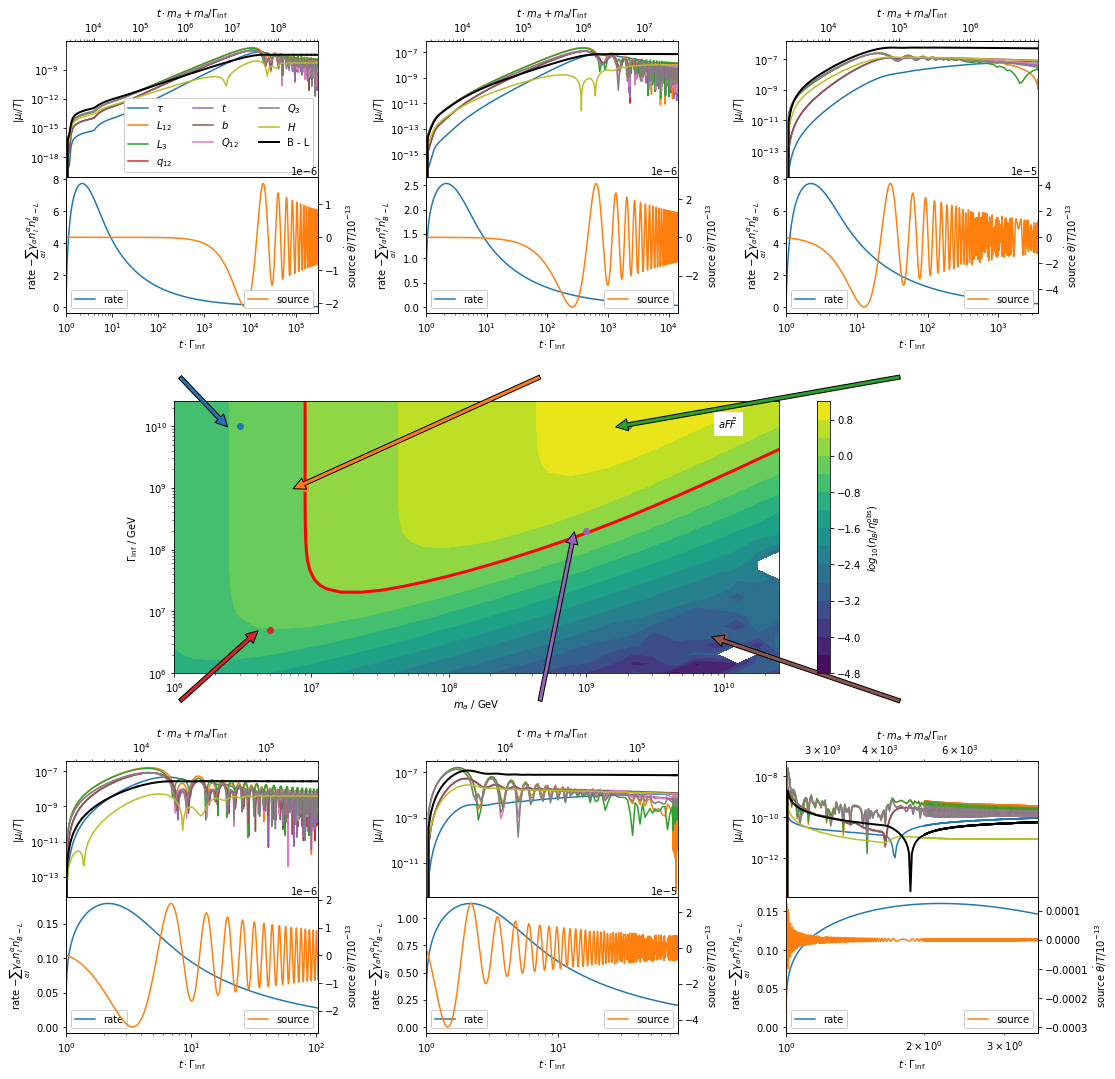

In [17]:
m_a, Gamma_inf = data["m_a"], data["Gamma_inf"]
H_inf = data["H_inf"][H_inf_index]
A = np.log10(np.abs(eta) / eta_B_observed)
levels = list(find_level(np.log10(m_a), np.log10(Gamma_inf), A))

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig_inv_trans = fig.transFigure.inverted()

subfig_fig = []

for nth_point, (i, j) in enumerate(itertools.product([0, 2], range(3))):        
    axs[i, j].remove()
    gridspec = axs[i, j].get_subplotspec().get_gridspec()
    subfig = fig.add_subfigure(gridspec[i, j])
    ax1, ax2 = subfig.subplots(2, 1)
    border = 0.15
    subfig.subplots_adjust(hspace=0, left=border, right=1 - border)
    dist = 0.05
    subfig_fig.append(fig_inv_trans.transform(
        subfig.transSubfigure.transform((0.5, 1 + dist) if i == 2 else (0.5, -dist))))

    conv_factor, ts, sources, rates,conv_factorkground_sols, axion_sols, red_chem_pot_sols = \
        interesting_solutions[nth_point]

    plot_charge_evolution(conv_factor, axion_sols, red_chem_pot_sols, show_steps=False, 
                          fig=subfig, ax=ax1, show_legend=nth_point == 0)
    ax1.set_xlim(ts[0], ts[-1])
    ax1.set_xticks([],[])
    secax = ax1.secondary_xaxis("top", 
        functions=(lambda inf: inf / conv_factor, lambda ax: ax * conv_factor))
    secax.set_xlabel(r"$t \cdot m_a + m_a / \Gamma_\mathrm{inf}$")

    ax_twin = ax2.twinx()
    ax2.semilogx(ts, rates, color="tab:blue", label="rate")
    ax_twin.semilogx(ts, sources, color="tab:orange", label="source")
    ax2.set_xlabel(r"$t \cdot \Gamma_\mathrm{inf}$")
    ax2.set_ylabel(r"rate $- \sum_{\alpha i} \gamma_\alpha n^\alpha_i n_{B - L}^i$")
    ax_twin.set_ylabel(r"source $\dot{\theta} / T / 10^{-13}$")
    ax2.legend(loc=3, framealpha=1)
    ax_twin.legend(loc=4, framealpha=1)
    ax2.set_xlim(ts[0], ts[-1])
    
for j in range(3):
    axs[1, j].remove()
gridspec = axs[1, 0].get_subplotspec().get_gridspec()
subfig = fig.add_subfigure(gridspec[1, :])
ax = subfig.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
mappable = ax.contourf(m_a, Gamma_inf, A, levels=15)

for xs, ys in levels:
    ax.plot(10**xs, 10**ys, "r", lw=3)
    
ax.set_xlabel("$m_a$ / GeV")
ax.set_ylabel(r"$\Gamma_\mathrm{inf}$ / GeV")
ax.annotate(r"$a F \tilde{F}$", (0.9, 0.9), xycoords="axes fraction", backgroundcolor="white")
subfig.colorbar(mappable, ax=ax,label=r"$log_{10}(\eta_B / \eta_B^\mathrm{obs})$")

interesting_points_marker_colors = []
interesting_points_fig = []
for p in interesting_points:
    l, = ax.plot(*p, "o")
    interesting_points_marker_colors.append(l.get_markerfacecolor())
    interesting_points_fig.append(fig_inv_trans.transform(ax.transData.transform(p)))
    
for arrow_end, arrow_start, arrow_color in zip(interesting_points_fig, subfig_fig, 
                                               interesting_points_marker_colors):
    ax.annotate("", xy=arrow_end, xytext=arrow_start, xycoords="figure fraction", 
                 textcoords="figure fraction", arrowprops=dict(facecolor=arrow_color))

#fig.suptitle(f"$f_a = {latex_exponential_notation(f_a, 2)}, H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)}$")

## Correct curves as a function of $f_a$

Text(0.5, 1.0, '$\\eta_B = \\eta_B^\\mathrm{obs}$ for $H_\\mathrm{inf} = 2.51\\cdot 10^{10} \\, \\mathrm{GeV}$')

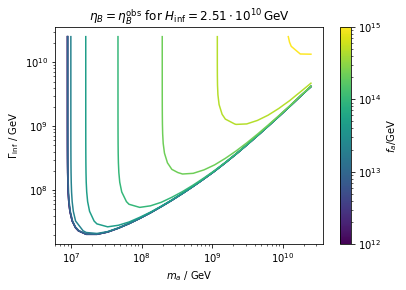

In [27]:
version = 1
correct_alp_curves_filename = os.path.join(runner.datadir, f"generic_alp_correct_curves{version}.pkl")
with open(correct_alp_curves_filename, "rb") as fhandle:
    f_a_list, correct_asym_curves = pickle.load(fhandle)
    
cmap = plt.cm.get_cmap("viridis")
norm = mpl.colors.LogNorm(vmin=np.min(f_a_list), vmax=np.max(f_a_list))
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for f_a, curve in zip(f_a_list, correct_asym_curves):
    c = mappable.to_rgba(f_a)
    for xs, ys in curve:
        plt.loglog(xs, ys, color=c)

plt.colorbar(mappable=mappable, label=r"$f_a / \mathrm{GeV}$")
plt.xlabel("$m_a$ / GeV")
plt.ylabel(r"$\Gamma_\mathrm{inf}$ / GeV")
plt.title(f"$\\eta_B = \\eta_B^\\mathrm{{obs}}$ for $H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)} \\, \\mathrm{{GeV}}$")

## Debug Example Evolutions

In [15]:
f_a = 1e15
H_inf = f_a*2*np.pi*1e-5 
def example_evolution(Gamma_inf, m_a):
    return compute_observables(H_inf, Gamma_inf, (m_a,), f_a, 
                        realignment_axion_field, (1.0, 0.0),
                        calc_init_time=True, debug=True)

conv factor: 0.1
step = 1
T_max = 5.602381e+12
t_eq = 2.9026457685899234
tmax_inf_time = 2.9026457685899234, tmax_axion_time = 29.02645768589923
calculcated initial integration time:
tmax_inf_time = 2.9026457685899234 tmax_axion_time = 29.02645768589923
rh: 0.3612494468688965
axion: 0.6022212505340576
transport eq.: 0.4687681198120117
B-L start .. end: 0.0 -1.2319344927125616e-08
B-L range: -2.5610810900200877e-08 0.0
delta = 1.7271327608592897 rtol_asym = 0.001
step = 2
rh: 0.0020101070404052734
axion: 0.08825898170471191
transport eq.: 0.22208809852600098
B-L start .. end: -1.231934492712562e-08 -1.1754108088035177e-08
B-L range: -1.2337970470884281e-08 -1.1752906587091664e-08
delta = 0.048446907818957066 rtol_asym = 0.001
step = 3
rh: 0.002095937728881836
axion: 0.08105278015136719
transport eq.: 0.21858978271484375
B-L start .. end: -1.175410808803518e-08 -1.1591730123140683e-08
B-L range: -1.17824284760459e-08 -1.1588713128331005e-08
delta = 0.016563753663013457 rtol_asym = 0.001


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


initial (rad, axion): 8.662113798917072e+47 3.3466840572797793e+41
axion decay took: 0.19838237762451172 seconds


/home/anna-jana/Documents/masters-project/transport_eq_in_time/decay_process.py:13: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(rho_field + rho_rad) * C # NOTE: sometimes with is evalulated at weird arguments -> warnings


(9.905220002554224e-11,
 0.00392631497409953,
 8.662113798917072e+47,
 3.3466840572797793e+41,
 0.0,
 1.0)

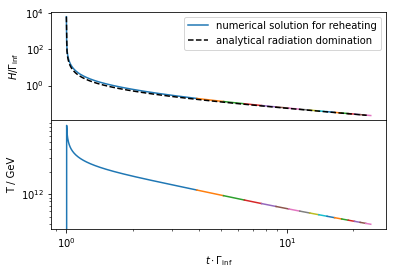

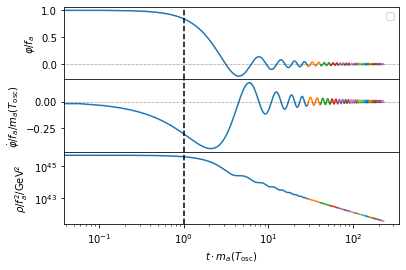

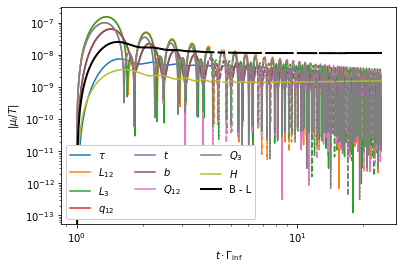

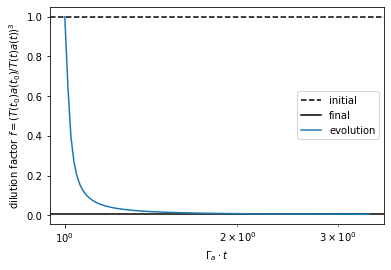

In [12]:
example_evolution(1e7, 1e8)

conv factor: 10.0
step = 1
T_max = 9.962599e+12
t_eq = 36.93447988685768
tmax_inf_time = 36.93447988685768, tmax_axion_time = 3.693447988685768
calculcated initial integration time:
tmax_inf_time = 36.93447988685768 tmax_axion_time = 3.693447988685768
rh: 0.11007285118103027
axion: 0.1679668426513672
transport eq.: 0.20083284378051758
B-L start .. end: 0.0 -5.5967526737437356e-08
B-L range: -5.5967526737437356e-08 0.0
delta = 4.9076743147765445 rtol_asym = 0.001
step = 2
rh: 0.008522510528564453
axion: 0.16575837135314941
transport eq.: 0.33674001693725586
B-L start .. end: -5.5967526737437356e-08 -7.456012648023222e-08
B-L range: -7.458797064071952e-08 -5.5967526737437356e-08
delta = 0.284342319843011 rtol_asym = 0.001
step = 3
rh: 0.00012183189392089844
axion: 0.07071566581726074
transport eq.: 0.26708483695983887
B-L start .. end: -7.456012648023222e-08 -7.45848102509307e-08
B-L range: -7.488516499354523e-08 -7.456012648023222e-08
delta = 0.004351345145735184 rtol_asym = 0.001
step 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


initial (rad, axion): 2.6589776457057805e+46 2.4825638413138115e+40


/home/anna-jana/Documents/masters-project/transport_eq_in_time/decay_process.py:13: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(rho_field + rho_rad) * C # NOTE: sometimes with is evalulated at weird arguments -> warnings


axion decay took: 0.22452688217163086 seconds


(6.39619749802244e-10,
 0.0001228697464385378,
 2.6589776457057805e+46,
 2.4825638413138115e+40,
 0.0,
 1.0)

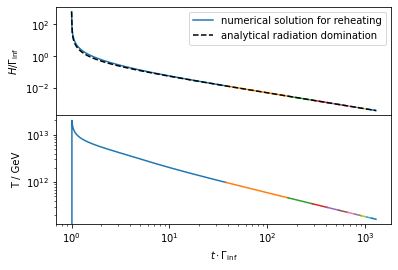

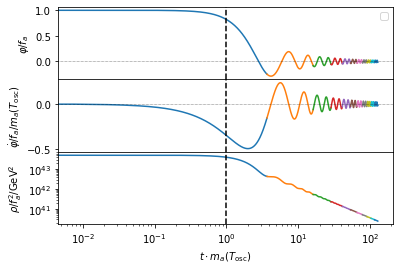

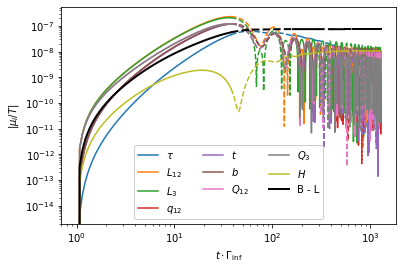

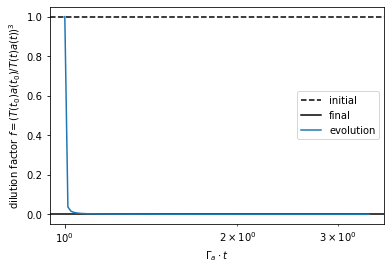

In [13]:
example_evolution(1e8, 1e7)